In [1]:
import numpy as np
from datetime import datetime
import pandas as pd 
import time
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.cloud import storage
BUCKET = "finance584"
client = storage.Client()
print("Client created using default project: {}".format(client.project))
bucket = client.get_bucket(BUCKET)
print("Bucket name: {}".format(bucket.name))
print("Bucket location: {}".format(bucket.location))
print("Bucket storage class: {}".format(bucket.storage_class))

Client created using default project: fast-haiku-332223
Bucket name: finance584
Bucket location: US-EAST1
Bucket storage class: STANDARD


In [2]:
# Load X and y
import numpy as np
from datetime import datetime
import pandas as pd 
import time
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

blob = bucket.get_blob("data_store/cnn_df3_X.npy")
with blob.open("rb") as f:
    X = np.load(f)
    
blob = bucket.get_blob("data_store/cnn_df3_y.npy")
with blob.open("rb") as f:
    y = np.load(f)

In [3]:
# X = np.load("data_store/cnn_df3_X.npy")
# y = np.load("data_store/cnn_df3_y.npy")

In [4]:
# Reshape X
X = X.reshape([406789,40,40,1])
y = y.reshape([406789,1])

In [5]:
# items:406789
# split to train and test
# from 2016-01-04 to 2020-12-31; from 2021-01-04 to 2021-09-23
X_train = X[:353700]
y_train = y[:353700]
X_test = X[353700:]
y_test = y[353700:]
# set validation
X_val = X_train[-50000:]
y_val = y_train[-50000:]
X_train = X_train[:-50000]
y_train = y_train[:-50000]

In [6]:
# print the shape
print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)
print("X_val shape:",X_val.shape)
print("y_val shape:",y_val.shape)
print("X_test shape:",X_test.shape)
print("y_test shape:",y_test.shape)

X_train shape: (303700, 40, 40, 1)
y_train shape: (303700, 1)
X_val shape: (50000, 40, 40, 1)
y_val shape: (50000, 1)
X_test shape: (53089, 40, 40, 1)
y_test shape: (53089, 1)


### Train

In [7]:
import tensorflow as tf
from tensorflow.keras import *
from tensorflow import keras

In [8]:
# plot the loss and acc, set the callbacks
# reference https://blog.csdn.net/wyx100/article/details/81096192
class Hist_Callbacks(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
 
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_accuracy'))
 
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('accuracy'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_accuracy'))
        
    def get_loss_and_acc(self):
        call_list = {}
        call_list["train_loss"] = self.losses["epoch"]
        call_list["train_acc"] = self.accuracy["epoch"]
        call_list["val_loss"] = self.val_loss["epoch"]
        call_list["val_acc"] = self.val_acc["epoch"]
        return call_list
        
    def loss_plot_loss(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.title('Loss of Model')
        plt.ylim(0,5)
        # plot the loss, train
        plt.plot(iters, self.losses[loss_type], 'r', label='train_loss')
        # plot the loss, val
        plt.plot(iters, self.val_loss[loss_type], 'b', label='val_loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('loss')
        plt.legend(loc="upper right")
        plt.show()
        
    def loss_plot_acc(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.title('Accuracy of Model')
        plt.ylim(0, 1)
        # plot the acc, train
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train_acc')
        # plot the acc, val
        plt.plot(iters, self.val_acc[loss_type], 'b', label='val_acc')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc')
        plt.legend(loc="upper right")
        plt.show()

In [9]:
class Residual(tf.keras.Model):  #@save
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(num_channels, padding='same',
                                            kernel_size=3, strides=strides,kernel_regularizer=regularizers.l2(l=0.01))
        self.conv2 = tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                            padding='same',kernel_regularizer=regularizers.l2(l=0.01))
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                                                strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

In [10]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(40, (3, 3),activation='relu',strides=2, padding='same',input_shape=(40, 40, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(ResnetBlock(40, 2, first_block=True))
model.add(ResnetBlock(80, 2))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(units=640,activation="relu"))
model.add(layers.Dense(units=7, activation="softmax"))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 40)        400       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 40)        0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 40)        0         
_________________________________________________________________
resnet_block (ResnetBlock)   (None, 10, 10, 40)        58400     
_________________________________________________________________
resnet_block_1 (ResnetBlock) (None, 5, 5, 80)          206480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 80)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2000)             

In [14]:
# tf.keras.utils.plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=True,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=80,
# )

In [15]:
# create history
history = Hist_Callbacks()
#opt = tf.keras.optimizers.SGD(learning_rate=0.9)
#opt = "adam"
#opt = keras.optimizers.Adam(learning_rate=0.3)
opt = "adam"
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.fit(X_train, y_train, epochs=10,batch_size=400,verbose = 2,
                    validation_data=(X_val, y_val), callbacks = [history])

Epoch 1/10
760/760 - 363s - loss: 2.2403 - accuracy: 0.2771 - val_loss: 1.7155 - val_accuracy: 0.2589
Epoch 2/10
760/760 - 359s - loss: 1.6251 - accuracy: 0.2943 - val_loss: 1.7277 - val_accuracy: 0.2523
Epoch 3/10
760/760 - 363s - loss: 1.6096 - accuracy: 0.3075 - val_loss: 1.7426 - val_accuracy: 0.2497
Epoch 4/10
760/760 - 359s - loss: 1.5875 - accuracy: 0.3255 - val_loss: 1.7707 - val_accuracy: 0.2476
Epoch 5/10
760/760 - 359s - loss: 1.5576 - accuracy: 0.3452 - val_loss: 1.7761 - val_accuracy: 0.2535
Epoch 6/10
760/760 - 361s - loss: 1.5268 - accuracy: 0.3607 - val_loss: 1.7637 - val_accuracy: 0.2514
Epoch 7/10
760/760 - 361s - loss: 1.5025 - accuracy: 0.3736 - val_loss: 1.8008 - val_accuracy: 0.2495
Epoch 8/10
760/760 - 360s - loss: 1.4710 - accuracy: 0.3855 - val_loss: 1.7784 - val_accuracy: 0.2492
Epoch 9/10
760/760 - 361s - loss: 1.4455 - accuracy: 0.3946 - val_loss: 1.7781 - val_accuracy: 0.2460
Epoch 10/10
760/760 - 360s - loss: 1.4182 - accuracy: 0.4067 - val_loss: 1.7567 - 

In [18]:
# save the model
model.save('model/resnet_model')

2021-11-15 05:53:26.873597: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/resnet_model/assets


### Evaluate

In [19]:
# evaluate train and val
score = model.evaluate(X_train, y_train, verbose=0)
print('Test score of train dataset:', score[0])
print('Test accuracy of train dataset:', score[1])
score = model.evaluate(X_val, y_val, verbose=0)
print('Test score of validation dataset:', score[0])
print('Test accuracy of validation dataset:', score[1])

Test score of train dataset: 1.368787169456482
Test accuracy of train dataset: 0.4341126084327698
Test score of validation dataset: 1.756729245185852
Test accuracy of validation dataset: 0.24782000482082367


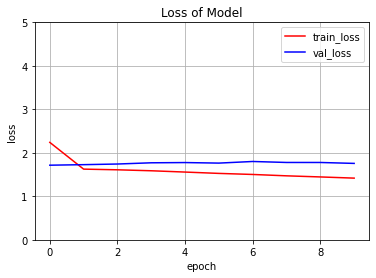

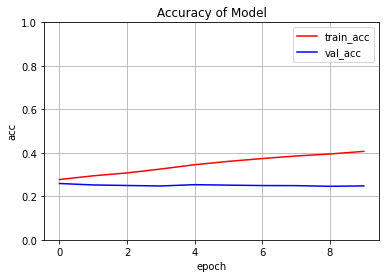

In [20]:
# plot the loss and accuracy of train and val 
loss_type = "epoch"
history.loss_plot_loss(loss_type)
history.loss_plot_acc(loss_type)

In [21]:
# evaluate test data
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score of test dataset:', score[0])
print('Test accuracy of test dataset:', score[1])

Test score of test dataset: 1.7901986837387085
Test accuracy of test dataset: 0.23375840485095978


In [22]:
# get the data
call_return = history.get_loss_and_acc()
call_return_df = pd.DataFrame(call_return)
call_return_df

,train_loss,train_acc,val_loss,val_acc
0,2.240283,0.277112,1.715451,0.25892
1,1.625118,0.294300,1.727742,0.25226
2,1.609614,0.307537,1.742567,0.24974
3,1.587459,0.325515,1.770650,0.24762
4,1.557580,0.345229,1.776101,0.25352
5,1.526825,0.360747,1.763697,0.25136
6,1.502474,0.373599,1.800837,0.24954
7,1.470988,0.385532,1.778403,0.24916
8,1.445491,0.394626,1.778051,0.24602
9,1.418162,0.406668,1.756730,0.24782


In [23]:
# save the data
! pip install openpyxl
call_return_df.to_excel('resnet_loss_acc.xlsx')

### Load Model And Print the Posibility

In [24]:
load_model = keras.models.load_model('model/resnet_model')

In [25]:
y_pred = load_model.predict(X_test)
y_pred

array([[5.29109457e-07, 1.23902690e-02, 2.01443225e-01, ...,
        2.21699029e-01, 2.88736403e-01, 6.42512366e-02],
       [2.40479581e-10, 1.15802912e-02, 3.29426199e-01, ...,
        2.74344355e-01, 1.64197117e-01, 2.04193816e-02],
       [6.30958084e-07, 7.37481788e-02, 1.73680514e-01, ...,
        1.74091488e-01, 2.65804857e-01, 1.89827710e-01],
       ...,
       [9.98463365e-04, 7.51002431e-02, 2.33514845e-01, ...,
        2.16226876e-01, 1.82864845e-01, 7.38845840e-02],
       [5.49468609e-07, 1.45916134e-01, 1.92795485e-01, ...,
        1.14264555e-01, 2.51113772e-01, 1.84033781e-01],
       [3.59304358e-05, 1.02959879e-01, 2.30329454e-01, ...,
        1.69976726e-01, 1.88216448e-01, 1.22831784e-01]], dtype=float32)

In [26]:
np.save('y_resnet.npy',y_pred)